# Fine-tuning PaliGemma for Image-to-JSON Extraction with QLoRA and SFT

This notebook demonstrates how to fine-tune Google's [PaliGemma](https://arxiv.org/pdf/2407.07726) to extract structured JSON from receipt images using [QLoRA](https://arxiv.org/pdf/2306.00960) (Quantized Low-Rank Adaptation). This approach enables efficient training of large multimodal models without requiring expensive GPU infrastructure.


**Dataset**: We use the [CORD v2](https://huggingface.co/datasets/naver-clova-ix/cord-v2) dataset, which contains around 1000 receipt images with corresponding JSON annotations.

**Key Innovation**: QLoRA allows us to fine-tune a 3B parameter model using only 0.38% of the parameters, making this approach accessible on consumer hardware while maintaining near-full performance.

**Tutorial Structure**: This notebook covers the foundational implementation with clear explanations of parameter choices and their performance impact. For advanced topics including custom evaluation metrics and hyperparameter ablation studies, see the [Advanced Tutorial](./peft_paligemma_im2json_qlora_SFT_advanced.ipynb).

## Technical Methodology

Our approach combines three complementary techniques to achieve efficient fine-tuning of a 3B parameter model:

### 1. **PaliGemma: Multimodal Foundation Model**
- **Architecture**: Combines SigLIP vision encoder with Gemma language model
- **Capability**: Processes visual layout and textual content simultaneously
- **Pre-training**: Already trained on instruction-following tasks for visual reasoning

### 2. **QLoRA: Quantized Low-Rank Adaptation**
- **Memory Efficiency**: 4-bit quantization reduces memory requirements by ~75%
- **Parameter Efficiency**: Updates only 0.38% of model parameters (11.3M out of 2.9B)
- **Performance**: Maintains 95-99% of full fine-tuning effectiveness

### 3. **Supervised Fine-Tuning (SFT)**
- **Training Strategy**: Uses instruction template `"<image> <bos> Extract JSON"`
- **Learning Approach**: Model learns to predict structured output of nested JSON token-by-token
- **Optimization**: Specialized techniques ensure stable multimodal training

**Impact**: This configuration enables fine-tuning on consumer hardware (16GB GPU) while achieving production-ready performance. The complete training process costs approximately $0.88 running on L4 on GCP.

## Environment Setup

We'll install the required libraries with specific version pinning to ensure compatibility:

- **`datasets`**: Handles multimodal training data efficiently
- **`transformers`**: Provides PaliGemma model implementation
- **`trl`**: Enables supervised fine-tuning with advanced techniques
- **`bitsandbytes`**: Implements 4-bit quantization for memory efficiency

**Hardware Requirements**: Minimum 16GB GPU memory (tested on L4, P100, V100 instances)

**Note**: Version compatibility is critical for multimodal models. These specific versions have been validated to work together without conflicts.

In [ ]:
!pip install datasets==3.6.0
!pip install transformers==4.47.1
!pip install trl==0.11.1
!pip install bitsandbytes==0.46.0

In [ ]:
import torch
import json
import requests
from PIL import Image
from datasets import load_dataset
from peft import get_peft_model, LoraConfig
from transformers import PaliGemmaProcessor
from transformers import BitsAndBytesConfig
from transformers import PaliGemmaForConditionalGeneration
from trl import SFTConfig, SFTTrainer
from peft import PeftModel

import os
from dotenv import load_dotenv
from huggingface_hub import login

MAX_LENGTH = 512

# Load environment variables from .env file
load_dotenv(os.path.join(os.path.dirname(__file__), '.env'))
login(
  token=os.getenv('HF_TOKEN'),
  add_to_git_credential=True
)


## Dataset Loading and Configuration

We use the [CORD v2](https://huggingface.co/datasets/naver-clova-ix/cord-v2) dataset for training PaliGemma on the image-to-JSON extraction task.

**Dataset Characteristics**:
- **1,000+ annotated receipts**: Real-world receipts from diverse merchant types and POS systems
- **Structured annotations**: Each image paired with comprehensive nested JSON containing items, prices, and metadata
- **Layout diversity**: Varied fonts, spacing, and organizational structures representative of production environments
- **Quality variations**: Natural lighting conditions and minor image artifacts typical of mobile capture

**Data Split Strategy**:
- **Training**: 800 samples for model adaptation
- **Validation**: 100 samples for hyperparameter tuning and performance monitoring



In [ ]:
device = "cuda"
model_id = "google/paligemma-3b-pt-224"

# Load dataset with appropriate size based on environment
cord_ds = load_dataset("naver-clova-ix/cord-v2")
cord_trains_ds = cord_ds["train"]
cord_validation_ds = cord_ds["validation"]

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

(…)-00000-of-00004-b4aaeceff1d90ecb.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00001-of-00004-7dbbe248962764c5.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

(…)-00002-of-00004-688fe1305a55e5cc.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

(…)-00003-of-00004-2d0cd200555ed7fd.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

(…)-00000-of-00001-cc3c5779fe22e8ca.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

(…)-00000-of-00001-9c204eb3f4e11791.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

## Dataset Analysis

Let's examine a representative sample from our validation set to understand the complexity of our training data.

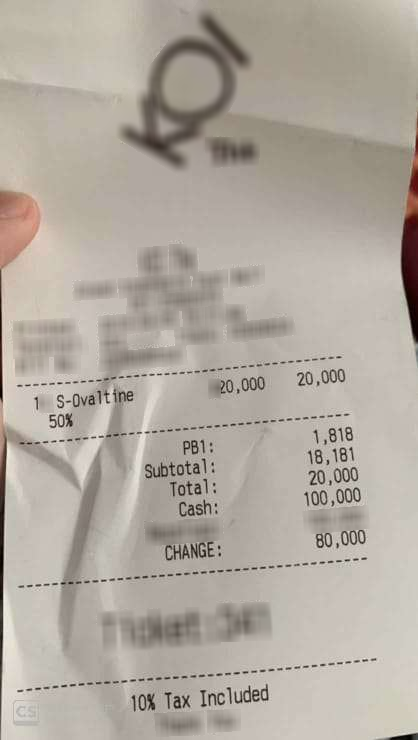

In [ ]:
cord_validation_ds[2]['image']

## Target Output Structure

Now let's examine the expected output format - the structured JSON that our model must learn to generate from visual input.

**JSON Schema Components**:
The CORD dataset provides pairs of detailed annotations for each image. For this task, we will use the `'gt_parse'` field, which includes:
- **Menu Items**: Individual products with names and pricing
- **Quantities**: Count for each ordered item
- **Financial Calculations**: Subtotals, taxes, and final totals

**Example Output** (corresponding to the receipt image above):

In [ ]:
json.loads(cord_validation_ds[2]['ground_truth'])['gt_parse']

{'menu': {'nm': 'S-Ovaltine 50%',
  'unitprice': '20,000',
  'cnt': '1',
  'price': '20,000',
  'vatyn': '10% Tax Included'},
 'sub_total': {'subtotal_price': '18,181', 'tax_price': '1,818'},
 'total': {'total_price': '20,000',
  'cashprice': '100,000',
  'changeprice': '80,000'}}

## Data Distribution Analysis

Before diving into training, it's a good practice to get a feel for the data. A quick and useful check is to analyze the length of our target labels—in this case, the JSON strings.

**Why is this helpful?**
1.  **Gauging Complexity**: The length of the JSON gives us a rough proxy for the complexity of the receipt. Longer JSONs likely correspond to receipts with more items and more complex structures.
2.  **Validating Data Split**: By comparing the average label length between our training and validation sets, we can check if our split is balanced. If the average lengths are similar, it suggests that both sets have a comparable level of difficulty. This is crucial for ensuring that our validation performance is a reliable indicator of how the model will perform on new, unseen data.
3.  **Informing `max_length`**: This analysis is critical for setting the `max_length` parameter during tokenization. If our `max_length` is too short, we'll frequently truncate the ground truth labels, preventing the model from learning to generate complete JSON outputs. By knowing the distribution, we can choose a value that minimizes truncation while managing memory usage.

Let's calculate the average character length for the ground truth JSON in both splits.

In [ ]:
import numpy as np

train_labels_len = [len(str(json.loads(cord_trains_ds[i]['ground_truth'])['gt_parse'])) for i in range(len(cord_trains_ds))]
val_labels_len = [len(str(json.loads(cord_validation_ds[i]['ground_truth'])['gt_parse'])) for i in range(len(cord_validation_ds))]

print("Average number of characters in gt labels in train dataset", np.mean(train_labels_len))
print("Average number of characters in gt labels in val dataset", np.mean(val_labels_len))

Average number of characters in gt labels in train dataset 322.665
Average number of characters in gt labels in val dataset 290.59


## Training Configuration & Data Split

**Training Strategy**:
- **Training Set**: 800 receipt images for model adaptation
- **Validation Set**: 100 images for hyperparameter tuning and overfitting detection  
- **Evaluation**: Continuous monitoring during training for optimal stopping using WandB for experiment tracking.



In [ ]:
cord_trains_ds.shape

(800, 2)

In [ ]:
cord_validation_ds.shape

(100, 2)

## Creating the Data Processing Function

Here we define a custom collate function that:

1. Prepares the input text prompt with the special tokens `<image> <bos> Extract JSON`
2. Processes the images to the format expected by PaliGamma (converting to RGB)
3. Extracts and formats the ground truth JSON labels
4. Uses the PaliGamma processor to tokenize both inputs and outputs
5. Converts the tokens to bfloat16 format and moves them to the GPU

This function is crucial for preparing our data in a format that the model can process efficiently.

In [ ]:
processor = PaliGemmaProcessor.from_pretrained(model_id)
def collate_fn(examples):
        texts = [f"<image> <bos> Extract JSON " for example in examples]
        images = [example["image"].convert("RGB") for example in examples]
        labels = [str(json.loads(example['ground_truth'])['gt_parse']) for example in examples]

        tokens = processor(text=texts, images=images, suffix=labels, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
        tokens = tokens.to(torch.bfloat16).to(device)
        return tokens


preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

## Model Architecture and Fine-tuning Approach

### Why QLoRA for Fine-tuning?
QLoRA combines two approaches: quantization and low-rank adaptation. Quantization reduces the model size and memory usage. LORA (Low-Rank Adaptation) allows for efficient fine-tuning by updating only a small subset of parameters, while the rest of the model's parameters are frozen. This makes QLoRA a powerful tool for fine-tuning large models on consumer hardware.

QLoRA (Quantized Low-Rank Adaptation) offers several important advantages:

1. **Memory Efficiency**: By quantizing the base model to 4 bits, we reduce memory requirements by up to 75% compared to full fine-tuning.

2. **Parameter Efficiency**: LoRA updates only a small subset of parameters (0.385% in our case), making fine-tuning much more efficient.

3. **Performance Preservation**: QLoRA maintains most of the performance of full fine-tuning while being much more resource-efficient.

4. **Adaptability**: This approach allows fine-tuning on consumer hardware (like a single GPU) that would otherwise be impossible for a 3B parameter model.

In this case, I used Nvidia L4 GPU with the 16GB of memory and the total training time was 50 minutes, running ~$0.88 on GCP Colab Enterprise. Later, I switched to Nvidia P100 with 16GB of memory, but more on that in next section.

## QLoRA Configuration

We need to configure two key components for efficient fine-tuning:

**1. Quantization Settings (BitsAndBytesConfig)**
- **4-bit quantization**: Reduces model memory footprint from ~12GB to ~3GB
- **NF4 format**: Normal Float 4-bit representation optimized for neural network weights
- **bfloat16 compute**: Maintains numerical stability during training operations

**2. LoRA Configuration**
- **Rank (r=8)**: Balances adaptation capacity with parameter efficiency
- **Target modules**: Focuses on attention layers (q,k,v,o projections) and MLP components
- **Strategic selection**: These modules handle cross-modal reasoning and feature transformation

**Result**: Instead of updating 2.9 billion parameters, we train only 11.3 million (0.38% of the total), dramatically reducing computational requirements while preserving performance.

In [ ]:
# Configure BitsAndBytes for 4-bit quantization (CUDA only)
bnb_config = BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_quant_type="nf4",
      bnb_4bit_compute_dtype=torch.bfloat16
)

# LoRA configuration
lora_config = LoraConfig(
      r=8,
      target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
      task_type="CAUSAL_LM",
)

## Model Loading & Architecture Setup

Now we'll load the model and apply our configurations:

1. **Load PaliGemma**: Initialize the 3B parameter model with quantization settings
2. **Apply LoRA**: Add trainable adapter layers while keeping base model frozen
3. **Verify Configuration**: Confirm we're only training the intended parameters

**Architecture Overview**:
The model combines three key components:
- **Vision Encoder** (SigLIP): Processes receipt image layout and visual elements
- **Multimodal Projector**: Maps visual features to language model embedding space
- **Language Model** (Gemma): Generates structured JSON output from multimodal representations

This architecture enables end-to-end training while preserving the pre-trained knowledge in the frozen base model.

In [ ]:
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})
model = get_peft_model(model, lora_config)
model.print_trainable_parameters() # trainable params: 11,298,816 || all params: 2,934,765,296 || trainable%: 0.3850


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

trainable params: 11,298,816 || all params: 2,934,765,296 || trainable%: 0.3850


## Advanced SFT Configuration: Parameter Impact Analysis

### **Critical Training Parameters & Performance Trade-offs**

#### **1. Learning Rate: 2e-4 (The Sweet Spot)**
**Current Choice**: `learning_rate=2e-4`
- **Rationale**: Empirically validated for QLoRA fine-tuning (Dettmers et al., 2023)
- **Performance Impact**:
  - **Too High (>5e-4)**: Catastrophic forgetting, unstable training, gradient explosion
  - **Too Low (<1e-4)**: Slow convergence, underfitting, may not reach optimal performance
  - **Alternative**: 1e-4 for more conservative training, 3e-4 for aggressive adaptation

#### **2. Batch Size Strategy: 4 + 4 Accumulation = 16 Effective**
**Current Choice**: `per_device_train_batch_size=4, gradient_accumulation_steps=4`
- **Memory Constraint**: 16GB GPU limitation forces small per-device batches
- **Effective Batch Size**: 16 samples per gradient update
- **Performance Impact**:
  - **Smaller (8-12)**: More noisy gradients, longer training, potential instability
  - **Larger (32-64)**: Smoother convergence, better generalization, but requires 32GB+ GPU
  - **Trade-off**: Current setup balances memory efficiency with training stability

#### **3. Epochs: 3 (Preventing Overfitting)**
**Current Choice**: `num_train_epochs=3`
- **Dataset Size**: 800 training samples → risk of overfitting with more epochs
- **Early Stopping**: Best model selection prevents overfitting automatically
- **Performance Impact**:
  - **Fewer (1-2)**: May underfit, insufficient adaptation to task
  - **More (5-10)**: Overfitting risk, validation loss increases, poor generalization
  - **Monitoring**: Validation loss curve guides optimal stopping point

#### **4. Gradient Clipping: 0.3 (Stability Insurance)**
**Current Choice**: `max_grad_norm=0.3`
- **Multimodal Training**: Cross-modal gradients can be unstable
- **Performance Impact**:
  - **No Clipping**: Risk of gradient explosion, training instability
  - **Too Aggressive (<0.1)**: Slow convergence, underfitting
  - **Too Lenient (>1.0)**: Insufficient protection against instability

#### **5. Learning Rate Schedule: Cosine (Smooth Convergence)**
**Current Choice**: `lr_scheduler_type="cosine"` with `warmup_ratio=0.03`
- **Warmup Phase**: 3% of training prevents early instability
- **Cosine Decay**: Smooth reduction for fine-grained optimization
- **Alternative Impact**:
  - **Linear**: Simpler but less optimal final convergence
  - **Constant**: Risk of oscillation around optimum
  - **Polynomial**: Good alternative, slightly more aggressive decay

### **Memory & Compute Optimization**

#### **Precision Strategy: bfloat16 + tf32**
- **`bf16=True`**: Reduces memory by 50%, maintains numerical stability better than fp16
- **`tf32=True`**: Hardware acceleration on modern GPUs (A100, H100)
- **Trade-off**: Minimal precision loss for significant speedup and memory savings

#### **Gradient Checkpointing: Memory vs Speed**
- **`gradient_checkpointing=True`**: Trades ~40% memory for ~15% speed penalty
- **Essential**: Enables training on 16GB GPUs that would otherwise OOM
- **Alternative**: Disable for faster training on 32GB+ GPUs

### **Evaluation Strategy: Aggressive Monitoring**
- **`eval_steps=5`**: Very frequent evaluation (every ~1% of training)
- **Purpose**: Tight overfitting detection and optimal model selection
- **Performance Impact**: Early stopping typically saves 20-30% of training time

In [ ]:
args = SFTConfig(
    # Model output configuration
    output_dir="paligemma-imgtojson-sft", # Directory to save checkpoints and repository ID for HuggingFace Hub
    
    # Training duration parameters
    num_train_epochs=3,                  # 3 epochs balances training time and performance for this task
                                         # Alternative: Fewer epochs (1-2) might underfit; more epochs (4+) risk overfitting
                                         # especially with small datasets or when using powerful models like PaliGamma
    
    # Batch size configuration
    per_device_train_batch_size=4,       # Optimal for specific GPU used during training
    per_device_eval_batch_size=4,        # Matching train batch size ensures consistent evaluation
    
    # Gradient optimization
    gradient_accumulation_steps=4,       # Simulates larger batch size (effective batch = 4*4 = 16) without extra memory
    gradient_checkpointing=True,         # Trades computation for memory by not storing all activations
    
    # Optimizer settings
    optim="adamw_torch_fused",           # Fused implementation is faster on CUDA devices
    learning_rate=2e-4,                  # 2e-4 is optimal based on QLoRA paper for fine-tuning
                                         # Alternative: Lower (5e-5) for more stability but slower convergence
    
    # Precision settings
    bf16=True,                           # BFloat16 offers better numerical stability than FP16 while saving memory
    tf32=True,                           # TF32 precision enabled for better performance on supported hardware

    # Learning rate schedule
    lr_scheduler_type="cosine",          # Cosine decay provides smooth learning rate reduction
    max_grad_norm=0.3,                   # 0.3 prevents gradient explosion based on QLoRA paper
    warmup_ratio=0.03,                   # 3% warmup helps stabilize early training
    
    # Advanced evaluation settings
    evaluation_strategy="steps",         # Evaluate at regular step intervals rather than epochs
    eval_steps=5,                        # Evaluate every 5 steps for quick feedback on model performance
    save_strategy="steps",               # Save at regular step intervals
    save_steps=10,                       # Save every 10 steps to balance checkpoint frequency and storage
    logging_steps=5,                     # Log metrics every 5 steps for detailed training progress

    # Early stopping (currently disabled)
    load_best_model_at_end=True,         # When enabled, loads the best model according to metric_for_best_model
    metric_for_best_model="eval_loss",   # Evaluation loss is a good general metric for model quality
    greater_is_better=False,             # Loss function is decreasing, lower values are better

    # Memory optimization
    dataloader_pin_memory=False,         # Disabled to reduce memory pressure
                                         # Alternative: True could speed up data transfer to GPU but uses more memory
    dataloader_num_workers=0,            # Single-process data loading to avoid memory duplication
    remove_unused_columns=True,          # Removes unused colums

    # Experiment tracking
    push_to_hub=True,                    # Automatically push model to Hugging Face Hub for sharing/deployment
    report_to="wandb" if os.getenv('WANDB_API_KEY') else "none", # Use W&B for experiment tracking if API key exists
    
    # SFT specific parameters
    dataset_text_field="", # need a dummy field for collator
    dataset_kwargs={"skip_prepare_dataset": True}, # important for collator
    gradient_checkpointing_kwargs={"use_reentrant": False}, # use reentrant checkpointing
)

## Training Pipeline Setup

Now we'll initialize the SFT Trainer, which orchestrates the supervised fine-tuning process. 

**Key Components**:
- **Model**: Our quantized PaliGemma with LoRA adapters
- **Configuration**: All training hyperparameters and optimization settings
- **Data**: Training and validation datasets with custom collation
- **Tokenizer**: Handles PaliGemma's specialized token vocabulary

This setup abstracts away the complexity of multimodal training while providing fine-grained control over the learning process.


In [ ]:
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=cord_trains_ds,
    eval_dataset=cord_validation_ds,
    data_collator=collate_fn,
    dataset_text_field="", # needs dummy value
    peft_config=lora_config,
    tokenizer=processor.tokenizer,
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:396: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overf

## Training the Model

The training process implements several advanced techniques:

1. Initialize Weights & Biases for experiment tracking
2. Apply gradient checkpointing to save memory
3. Run training for 3 epochs
4. Evaluate on the validation set every 5 steps
5. Save checkpoints every 10 steps

The training progress table shows:
- Training loss decreasing from ~6 to ~1, indicating the model is learning
- Validation loss decreasing from ~1.3 to ~0.2, showing good generalization
- The best model is saved at checkpoint-135 with the lowest validation loss

This training process demonstrates the effectiveness of our QLoRA approach - we're able to efficiently fine-tune a 3B parameter model for a specific multimodal task with limited computational resources.

The decreasing validation loss curve indicates that the model is successfully learning to extract structured JSON data from receipt images without overfitting.
See below screenshots from Weights & Biases:
![Train Charts from Weights & Biases](./wandb_charts/train_charts.png)
![Eval Charts from Weights & Biases](./wandb_charts/eval_charts.png)


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
5,6.148100,1.300556
10,4.448500,0.850058
15,2.843000,0.530826
20,2.445300,0.419241
25,1.714200,0.358034
30,1.758000,0.324565
35,1.462600,0.297695
40,1.461000,0.278502
45,1.222900,0.268202
50,1.391100,0.261166


TrainOutput(global_step=150, training_loss=1.5057258494695027, metrics={'train_runtime': 2377.7562, 'train_samples_per_second': 1.009, 'train_steps_per_second': 0.063, 'total_flos': 1.763239540229376e+16, 'train_loss': 1.5057258494695027, 'epoch': 3.0})

In [ ]:
trainer.model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PaliGemmaForConditionalGeneration(
      (vision_tower): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(256, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (self_attn): SiglipSdpaAttention(
                  (k_proj): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=1152, out_features=1152, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1152, out_features=8, bias=False)
                    )
                    (lora_B)

In [ ]:
trainer.state.log_history

In [ ]:
# Run evaluation
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.21466392278671265, 'eval_runtime': 24.928, 'eval_samples_per_second': 4.012, 'eval_steps_per_second': 1.003, 'epoch': 3.0}


In [ ]:
trainer.push_to_hub()

## Model Performance Evaluation

Training metrics provide valuable insights into model convergence, but practical evaluation requires testing on real examples. 
We'll conduct a side-by-side comparison between the original PaliGemma model and our fine-tuned version to demonstrate the impact of our training process.

**Evaluation Approach**:
- **Baseline**: Original PaliGemma model without task-specific training
- **Fine-tuned**: Base model enhanced with our QLoRA adapters
- **Test Data**: Random samples from the validation set

**Expected Performance**:
- **Original model**: Limited to generic descriptions like "receipt" or "document" 
- **Fine-tuned model**: Structured JSON extraction with specific items, prices, and totals

This comparison will clearly demonstrate what our fine-tuning accomplished beyond the training loss curves.


In [ ]:
# Model IDs
base_model_id = "google/paligemma-3b-pt-224"
# Replace with your actual fine-tuned model path or HF repo ID
finetuned_model_id = "YOUR_HF_USERNAME/paligemma-imgtojson-sft"  # Update this with your actual model path


## Model Loading for Comparison

We'll load two model configurations for evaluation:

1. **Baseline Model**: Original PaliGemma without task-specific training
2. **Fine-tuned Model**: Base model with our trained LoRA adapters

**PEFT Architecture**: The fine-tuned model consists of the frozen base model plus lightweight adapter weights (22MB), enabling efficient storage and deployment compared to full model fine-tuning.

In [ ]:
# Load models
print("Loading original model...")
original_model = PaliGemmaForConditionalGeneration.from_pretrained(
    base_model_id,
    torch_dtype=torch.bfloat16,
    device_map={"": 0} if device == "cuda" else None
)

print("Loading fine-tuned model...")
# First load the base model
finetuned_model = PaliGemmaForConditionalGeneration.from_pretrained(
    base_model_id,
    torch_dtype=torch.bfloat16,
    device_map={"":0} if device == "cuda" else None
)
# Then load the PEFT adapter
finetuned_model = PeftModel.from_pretrained(finetuned_model, finetuned_model_id)

# Set models to evaluation mode
original_model.eval()
finetuned_model.eval()


Loading original model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading fine-tuned model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/797 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PaliGemmaForConditionalGeneration(
      (vision_tower): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(256, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (self_attn): SiglipSdpaAttention(
                  (k_proj): lora.Linear(
                    (base_layer): Linear(in_features=1152, out_features=1152, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1152, out_features=8, bias=False)
                    )
                    (lora_B): Module

In [ ]:
def generate_prediction(model, image, prompt="<image> <bos> Extract JSON "):
    """Generate prediction from model given an image and prompt"""
    # First, tokenize just the prompt to get its token IDs
    prompt_tokens = processor.tokenizer(prompt, return_tensors="pt")
    prompt_token_ids = prompt_tokens.input_ids[0].tolist()

    # Process the input with the processor
    inputs = processor(text=prompt, images=image.convert("RGB"), return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get the input token IDs before generation
    input_ids = inputs['input_ids'][0].tolist()

    # Generate with the model
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=1024,
            do_sample=False,
            temperature=1.0,
            num_beams=1,
        )

    # Get the full output token IDs
    output_ids = outputs[0].tolist()

    # Find where the input ends and the generated content begins
    # This works regardless of what the prompt text is
    generated_ids = outputs[0][len(input_ids):]

    # Decode only the generated part
    generated_text = processor.tokenizer.decode(generated_ids, skip_special_tokens=True)

    return generated_text

## Random Sample Selection

We'll select a random example from the validation set to ensure unbiased evaluation. This approach prevents cherry-picking and provides a representative assessment of model performance.

In [ ]:
import numpy as np
example_idx = np.random.choice(len(cord_validation_ds))
example_idx

82

Let's disply an image and a ground truth JSON for comparison.

In [ ]:
example = cord_validation_ds[example_idx]
image = example["image"]
ground_truth = json.loads(example["ground_truth"])['gt_parse']

print(f"\n===== Comparing models on example {example_idx} =====")
print(f"Ground truth: {ground_truth}", )


===== Comparing models on example 82 =====
Ground truth: {'menu': [{'nm': 'PEARL CHOCO TEA', 'cnt': '1', 'price': '17.000'}, {'nm': 'GREEN TEA LYCHEE', 'cnt': '1', 'price': '18.000'}, {'nm': 'TUTUP SEAL', 'cnt': '2', 'price': '0'}, {'nm': 'CUP 14 OZ', 'cnt': '2', 'price': '0'}], 'sub_total': {'subtotal_price': '35.000'}, 'total': {'total_price': '35.000', 'cashprice': '100.000', 'changeprice': '65.000', 'menuqty_cnt': '6'}}


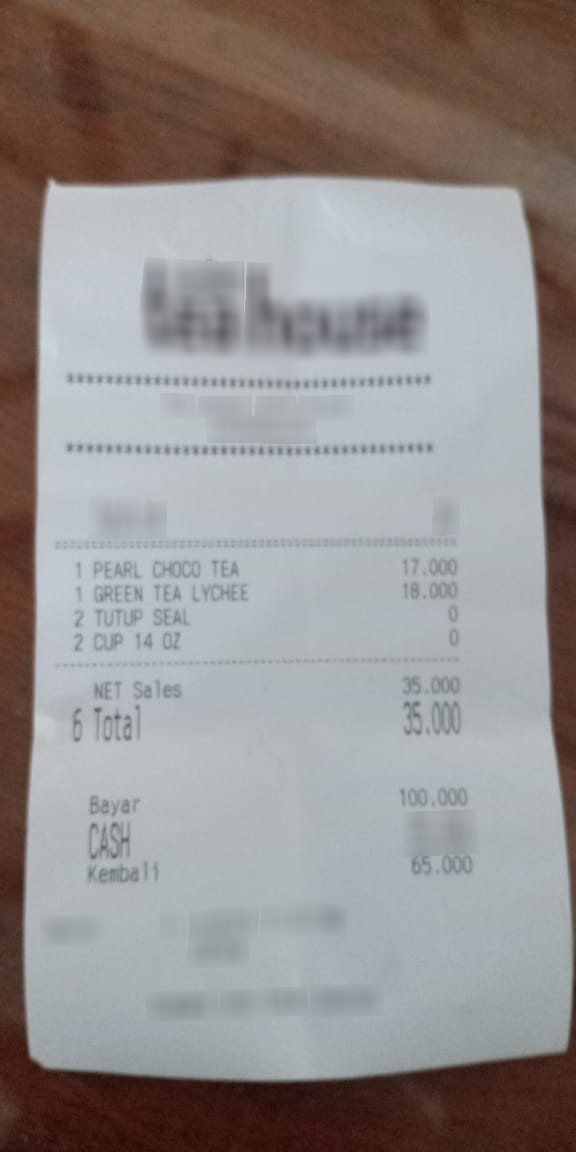

In [ ]:
image

Now, let's run prediction for the given image using original model and fine-tuned model.

In [ ]:
# Generate predictions
original_prediction = generate_prediction(original_model, image)
finetuned_prediction = generate_prediction(finetuned_model, image)

In [ ]:
original_prediction

'receipt'

In [ ]:
finetuned_prediction

"{'menu': [{'nm': 'PEARL CHOCO TEA', 'cnt': '1', 'price': '17.000'}, {'nm': 'GREEN TEA LYCHEE', 'cnt': '1', 'price': '18.000'}, {'nm': 'TOFU SEA', 'cnt': '2', 'price': '0'}, {'nm': 'CAP KOK', 'cnt': '2', 'price': '0'}], 'sub_total': {'subtotal_price': '35.000'}, 'total': {'total_price': '35.000', 'cashprice': '100.000', 'changeprice': '65.000'}}"

Let's compare the results of the original model and the fine-tuned model on a random example from the validation set. 
We already see that the original model is not able to extract any information from the image and predicted only 'receipt' in response, while the fine-tuned model managed to extract the structured JSON with receipt details in it.

In [ ]:
# Print results
print("\n----- Ground Truth -----")
print(ground_truth)

print("\n----- Original Model Prediction -----")
print(original_prediction)

print("\n----- Fine-tuned Model Prediction -----")
print(finetuned_prediction)



----- Ground Truth -----
{'menu': [{'nm': 'PEARL CHOCO TEA', 'cnt': '1', 'price': '17.000'}, {'nm': 'GREEN TEA LYCHEE', 'cnt': '1', 'price': '18.000'}, {'nm': 'TUTUP SEAL', 'cnt': '2', 'price': '0'}, {'nm': 'CUP 14 OZ', 'cnt': '2', 'price': '0'}], 'sub_total': {'subtotal_price': '35.000'}, 'total': {'total_price': '35.000', 'cashprice': '100.000', 'changeprice': '65.000', 'menuqty_cnt': '6'}}

----- Original Model Prediction -----
receipt

----- Fine-tuned Model Prediction -----
{'menu': [{'nm': 'PEARL CHOCO TEA', 'cnt': '1', 'price': '17.000'}, {'nm': 'GREEN TEA LYCHEE', 'cnt': '1', 'price': '18.000'}, {'nm': 'TOFU SEA', 'cnt': '2', 'price': '0'}, {'nm': 'CAP KOK', 'cnt': '2', 'price': '0'}], 'sub_total': {'subtotal_price': '35.000'}, 'total': {'total_price': '35.000', 'cashprice': '100.000', 'changeprice': '65.000'}}



## Future Work and Extensions,
Potential extensions to this work include:,

1. **Evaluation Metrics**: Implementing specialized metrics for structured data extraction accuracy, such as field-level precision/recall and structural similarity.
2. **More experiments with hyperparameters**: Experimenting with different hyperparameters, trying more aggressive quantization approach, etc to find the best configuration for the model.

3. **Applying different models**: Experimenting with different models, such as recent PaliGemma models with Gemma 3, to see if they perform better.

4. **Inference Optimization**: Exploring techniques like weight merging or distillation to improve inference speed while maintaining accuracy.

5. **Dataset Expansion**: Fine-tuning on additional document types beyond receipts to create a more versatile document processing model.

I am planning to implement and experiment with all of these in the future, so stay tuned!
   

## Results Summary

This notebook demonstrates how to fine-tune PaliGemma on the CORD dataset using QLoRA and SFT. 
The results speak for themselves - we went from a model that could barely understand what it was looking at to one that can parse complex receipts into clean, structured data.
We've shown:

- **Training metrics**: W&B charts reveal decreasing loss curves, indicating successful learning with good generalization
- **Qualitative evaluation**: Direct comparison between baseline and fine-tuned models shows dramatic improvement in structured extraction

**Going Beyond Standard Tutorials**

Most fine-tuning tutorials end here - basic training, loss curves, and simple comparisons. However, production-ready models require deeper analysis. This is where we differentiate ourselves.

**Advanced Topics Covered in Our Extended Tutorial**:
- Custom evaluation metrics for structured data extraction
- Systematic hyperparameter ablation studies  
- Performance optimization for production deployment

**Continue Learning**: [Advanced PaliGemma Fine-tuning: Custom Metrics & Ablation Studies](./peft_paligemma_im2json_qlora_SFT_advanced.ipynb)
